# Capstone Project: Car Accident Severity Prediction

## Applied Data Science Capstone by IBM

## Table of contents
1. [Introduction | Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Results](#results)
5. [Discussion](#discussion)
6. [Conclusion](#conclusion)
7. [References](#references)
8. [Bonus](#bonus)

## 1. Introduction | Business Problem<a id="introduction"></a>

The lives of approximately 1.35 million people are cut short as a result of a road traffic crash. Considerable economic loss is caused by road accidents to individuals, families, and the nation as a whole. Road traffic crashes cost most countries 3% of their Gross Domestic Product (GDP).<br>
In this project, we will try to predict the severity of car accidents. The various insights drawn from this report would be in the interest of the local authorities, municipal contractors, the traffic department, and the general public.

## 2. Data<a id="data"></a>

### 2.1 Understanding our Data

The data for this project has been provided by the Seattle Police Department and recorded by Traffic Records which has been shared with us via link by Coursera. The dataset contains collision records from 2004 to present in the city of Seattle.

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
# Importing Dataset
data_path = "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv"
df = pd.read_csv(data_path)
df.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


Looking at the data we can see our predictor or target variable "SEVERITYCODE" is a code that corresponds to the severity of the collision which ranges from 0 to 3. We can see what each code indicates below.

In [2]:
SEVERITY_LEGEND = pd.DataFrame({"SEVERITYCODE" : [ '0', '1', '2', '2b', '3'], "SEVERITY" : ["Unkown", "Property Damage", "Injury", "Serious Injury", "Fatality"]})
SEVERITY_LEGEND

,SEVERITYCODE,SEVERITY
0,0,Unkown
1,1,Property Damage
2,2,Injury
3,2b,Serious Injury
4,3,Fatality


Next, we can see we have around 37 attributes many of which we may not use for our model. We can also see that many of the columns have categorical values which we will have to convert into numerical values for using them as features.

In [3]:
print("Shape of Dataset: ",df.shape)
df.dtypes

Shape of Dataset:  (194673, 38)


SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

Upon further inspection, we notice how imbalanced our dataset is. About 70% of our records contain property damage. Hence our predictions would be limited to Injury and Property Damage. Using this dataset as our base for our models and analysis we may get a lot of errors and our models would be biased towards property damage. Hence we would have to balance our dataset to properly predict the severity of collisions.

In [4]:
# Importing Plotting Libraries
import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

# Plotting Distribution
rcParams['figure.figsize'] = 10,5
print('Distribution of the Classes in the dataset')
print(df["SEVERITYCODE"].value_counts()/len(df))
sns.countplot("SEVERITYCODE", data=df)
plt.title('Imbalanced Classes', fontsize=14)
plt.show()

Distribution of the Classes in the dataset
1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64


<Figure size 1000x500 with 1 Axes>

## 3. Methodology<a id="methodology"></a>

### 3.1 Exploratory Data Analysis

Before we start training our classifiers lets have a look at our features. 
We first went through the various attributes and rounded up the following ones which we thought would have the most impact in a car accident.

| Attribute     | Description                                                                    |
| --------------|--------------------------------------------------------------------------------|
| UNDERINFL     | Whether or not a driver involved was under the influence of drugs or alcohol.  |
| WEATHER       | A description of the weather conditions during the time of the collision.      |
| ROADCOND      | The condition of the road during the collision.                                |
| LIGHTCOND     | The light conditions during the collision.                                     |

Before we can visualize our attributes we found that the attribute "UNDERINFL" contained binary 1s and 0s along with Y (Yes) and N (No). Based on the below visualization we standardized the data to 0 as N and 1 as Y.

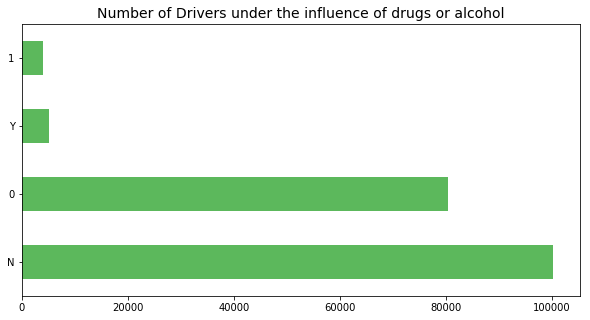

In [5]:
# Plotting "UNDERINFL"
df["UNDERINFL"].value_counts().sort_values(ascending=False).plot.barh(color=['#5cb85c'],align='center', figsize=(10,5))
plt.title('Number of Drivers under the influence of drugs or alcohol', fontsize=14)
plt.show

# Before we can visualize the attribute "UNDERINFL" we are standardizing the data (Here we are assuming the existing 0 denotes N and 1 denotes Y)
df["UNDERINFL"].replace(to_replace=['0','1'], value=['N','Y'],inplace=True)

Let's visualize our various attributes:

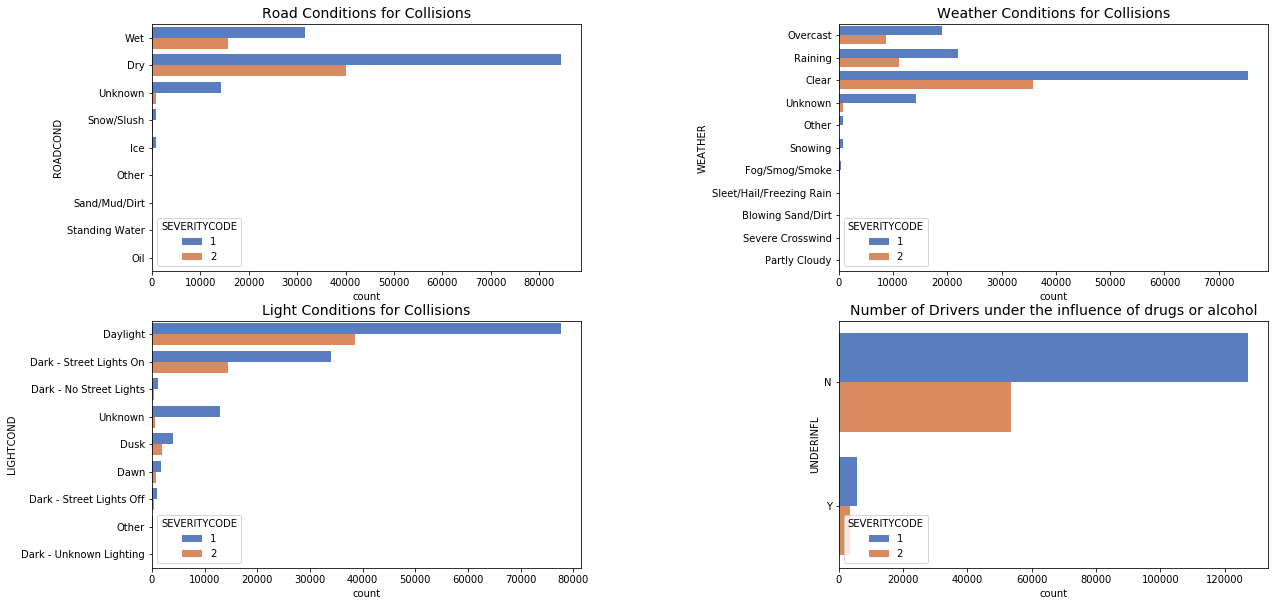

In [6]:
# Visualizing Attributes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
plt.subplots_adjust(wspace=0.6, hspace=0.2)
sns.countplot(data = df, y="ROADCOND", hue="SEVERITYCODE", palette="muted", ax=axes[0,0]).set_title('Road Conditions for Collisions', fontsize=14)
sns.countplot(data = df, y="WEATHER", hue="SEVERITYCODE", palette="muted", ax=axes[0,1]).set_title('Weather Conditions for Collisions', fontsize=14)
sns.countplot(data = df, y="LIGHTCOND", hue="SEVERITYCODE", palette="muted", ax=axes[1,0]).set_title('Light Conditions for Collisions', fontsize=14)
sns.countplot(data = df, y="UNDERINFL", hue="SEVERITYCODE", palette="muted", ax=axes[1,1]).set_title('Number of Drivers under the influence of drugs or alcohol', fontsize=14)
plt.legend(title='SEVERITYCODE', loc='lower left', labels=['1', '2'])
plt.show()

### 3.2 Pre-processing: Feature Selection / Extraction

Here we drop attributes that we don't need and drop null values.

In [7]:
# Dropping attributes that are not required
drop_col = ["X", "Y", "OBJECTID", "INCKEY", "COLDETKEY", "REPORTNO", "STATUS", "ADDRTYPE", "INTKEY", "LOCATION", "EXCEPTRSNCODE", "EXCEPTRSNDESC", "SEVERITYCODE.1", "SEVERITYDESC", "PERSONCOUNT", "PEDCOUNT", "PEDCYLCOUNT", "VEHCOUNT", "INCDTTM","INCDATE", "SDOT_COLCODE", "SDOT_COLDESC", "INATTENTIONIND", "PEDROWNOTGRNT", "SDOTCOLNUM", "ST_COLCODE", "ST_COLDESC", "SEGLANEKEY", "CROSSWALKKEY", "HITPARKEDCAR", "COLLISIONTYPE", "JUNCTIONTYPE", "SPEEDING"]
df.drop(drop_col, axis = 1, inplace = True)

# Dropping NaN Values
df.dropna(axis = 0, inplace = True)

### 3.3 Converting Categorical Values to Numerical Values

Using Scikit Learn's Label Encoder to convert categorical values to numerical values.

In [8]:
# Replacing N and Y with 0 and 1
df["UNDERINFL"].replace(to_replace=['N','Y'], value=[0,1],inplace=True)

# Importing Label Encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df["WEATHER"] = le.fit_transform(df["WEATHER"])
df["ROADCOND"] = le.fit_transform(df["ROADCOND"])
df["LIGHTCOND"] = le.fit_transform(df["LIGHTCOND"])

### 3.4 Feature Definition

We can now define our features and target variables.

In [9]:
X = df.iloc[:,1:6].to_numpy()
y = df.iloc[:,0].to_numpy()
print("Shape of X is",X.shape)
print("Shape of y is",y.shape)

Shape of X is (189337, 4)
Shape of y is (189337,)


### 3.5 Splitting our Dataset into Training and Test Set

We now split our dataset where we will use 70% of our data for training and 30% of our data for testing.

In [10]:
# Importing Train Test Split to split data set into training and testing data
from sklearn.model_selection import train_test_split

# Using train_test_split to split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
print("Shape of X_train is",X_train.shape)
print("Shape of y_train is",y_train.shape)
print("Shape of X_test is",X_test.shape)
print("Shape of y_test is",y_test.shape)

Shape of X_train is (132535, 4)
Shape of y_train is (132535,)
Shape of X_test is (56802, 4)
Shape of y_test is (56802,)


### 3.6 Training our Classifiers

Our data is now ready and we will be using the following classifiers:-
* Logistic Regression
* K-Nearest Neighbour (KNN)
* Decision Tree
* Random Boost Classifier
* Gaussian Naive Bayes
* XGBoost Classifier

We can now start training our classifiers.

In [11]:
# Importing Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


# Creation of Classifier Objects
classifiers = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GaussianNBClassifier": GaussianNB(),
    "XGBClassifier": XGBClassifier()
    
}

# Importing K Fold Cross Validation
from sklearn.model_selection import cross_val_score

temp = []

# Training our Classifiers
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean()* 100, 2) , "% accuracy score")
    temp.append([classifier.__class__.__name__, round(training_score.mean()* 100, 2)])
training_scores = pd.DataFrame(temp, columns=["Classifiers","Scores"])

Classifiers:  LogisticRegression Has a training score of 69.78 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 63.99 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 69.77 % accuracy score


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Classifiers:  RandomForestClassifier Has a training score of 69.76 % accuracy score
Classifiers:  GaussianNB Has a training score of 68.73 % accuracy score
Classifiers:  XGBClassifier Has a training score of 69.8 % accuracy score


## 4. Results<a id="results"></a>

After training our models let us check the accuracy of the models.

In [12]:
# Importing Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

temp = []
temp1 = []

# Testing our Classifiers
for key, classifier in classifiers.items():
    yhat = classifier.predict(X_test)
    test_score = round(metrics.accuracy_score(y_test, yhat) * 100,2)
    temp.append([classifier.__class__.__name__, test_score])
    temp1.append([classifier.__class__.__name__,accuracy_score(y_test, yhat), precision_score(y_test, yhat), recall_score(y_test, yhat), f1_score(y_test, yhat)])
test_scores = pd.DataFrame(temp, columns=["Classifiers","Scores"])
test_report = pd.DataFrame(temp1, columns=["Classifiers","accuracy","precision","recall","f1_score"])
print(test_scores)

              Classifiers  Scores
0      LogisticRegression   69.98
1    KNeighborsClassifier   64.40
2  DecisionTreeClassifier   70.01
3  RandomForestClassifier   70.01
4              GaussianNB   69.04
5           XGBClassifier   70.04


## 5. Discussion<a id="discussion"></a>

As we can see there isn't much of a difference in the accuracy scores. However we can see that K-Nearest Neighbor (KNN) has the lowest accuracy out of all the other models.

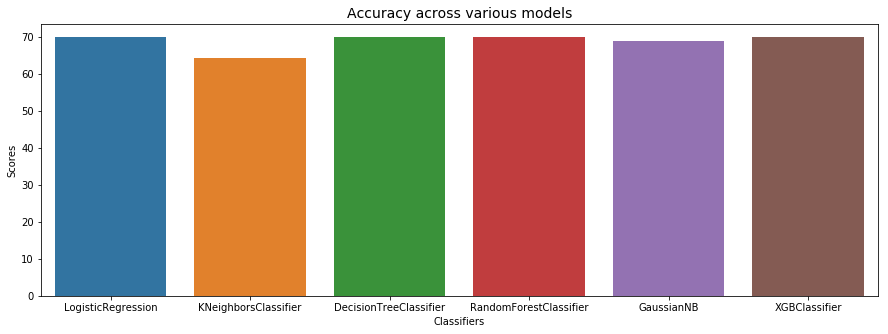

In [13]:
# Plotting Accuracy
rcParams['figure.figsize'] = 15,5
sns.barplot(x='Classifiers', y='Scores', data=test_scores)
plt.title('Accuracy across various models', fontsize=14)
plt.show()

**Understanding Accuracy, Precision, Recall, and F1 Score**

Accuracy - Accuracy is simply a ratio of correctly predicted labels to total labels. For example if we have an accuracy of 0.70 means that we are 70% accurate.

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. In the XGBoost Classifier we have got 0.70 precision which is pretty decent.

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to all observations in actual class - yes. In the XGBoost Classifier we have got recall of 1.00 which is impressive.

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. In the XGBoost Classifier our F1 score is 0.82. <br><br>

**Below we can see scores for all our trained models.**

In [14]:
print(test_report.round(2))

              Classifiers  accuracy  precision  recall  f1_score
0      LogisticRegression      0.70       0.70    1.00      0.82
1    KNeighborsClassifier      0.64       0.71    0.84      0.77
2  DecisionTreeClassifier      0.70       0.70    1.00      0.82
3  RandomForestClassifier      0.70       0.70    1.00      0.82
4              GaussianNB      0.69       0.71    0.96      0.81
5           XGBClassifier      0.70       0.70    1.00      0.82


Our models were trained with a limited set of features that were handpicked. As mentioned earlier the data being imbalanced with lack of data for the more severe categories the model is limited to predicting only Injury or Property Damage. In the future the model can be improved with usage of additional attributes and collision data for more severe categories. 

## 6. Conclusion<a id="conclusion"></a>

As per the data analysis and insights drawn we can conclude that there is a certain degree of relationship between certain attributes and car collisions. With about 70% of accuracy, we were able to predict the severity of the car accidents between injury and property damage. Since the data was restricted to injury and property damage we cannot comment on whether the factors mentioned would share a similar relationship with higher degrees of severity such as serious injuries and fatalities. With this report the local authorities can take stricter actions against persons driving under influence, municipal contractors can build better roads and the general public as a whole can be aware of the main causes of car accidents.

## 7. References<a id="references"></a>

* [Road Traffic Injuries - WHO](https://www.who.int/news-room/fact-sheets/detail/road-traffic-injuries)
* [Interpretation of Performance Measures](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)
* [Kaggle Notebook - Credit Fraud: Dealing with imbalanced datasets](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook)

## 8. Bonus<a id="bonus"></a>

Earlier I had mentioned that our data was imbalanced and we would require to balance it by performing under-sampling. After balancing my dataset and training my models the results were not what we expected.<br>
**The accuracy decreased.** <br>
Let us see how we balanced the data and trained our classifiers.

### 8.1 Random Under Sampling

As we saw earlier our dataset is heavily imbalanced. Hence we will create a dataframe with a 50/50 ratio of 1 (Property Damage) and 2 (Injury) severity cases. This is done to prevent overfitting.

Distribution of the Classes in the subsample dataset
2    0.5
1    0.5
Name: SEVERITYCODE, dtype: float64


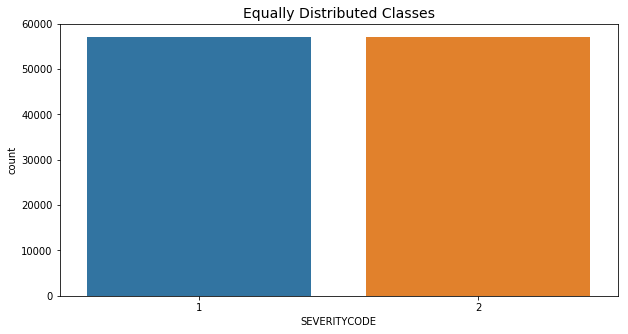

In [15]:
# Lets shuffle our data before creating subsamples
df = df.sample(frac=1)

# Splitting the data
injury_df = df.loc[df["SEVERITYCODE"] == 2]
prop_damage_df = df.loc[df["SEVERITYCODE"] == 1][:57052]

normal_distributed_df = pd.concat([injury_df, prop_damage_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

# Resetting the Index
new_df.reset_index(drop=True, inplace=True)

# Plotting Distribution
rcParams['figure.figsize'] = 10,5
print('Distribution of the Classes in the subsample dataset')
print(new_df["SEVERITYCODE"].value_counts()/len(new_df))
sns.countplot("SEVERITYCODE", data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### 8.2. Feature Definition, Classifier Training, and Results

In [16]:
# Feature Selection
X = new_df.iloc[:,1:6].to_numpy()
y = new_df.iloc[:,0].to_numpy()

# Using train_test_split to split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

# Importing Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier


# Creation of Classifier Objects
classifiers = {
    "LogisiticRegression": LogisticRegression(solver='liblinear'),
    "KNearest": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "GaussianNBClassifier": GaussianNB(),
    "XGBClassifier": XGBClassifier()
    
}

# Importing K Fold Cross Validation
from sklearn.model_selection import cross_val_score

temp = []

# Training our Classifiers
for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    temp.append([classifier.__class__.__name__, round(training_score.mean()* 100, 2)])
training_scores = pd.DataFrame(temp, columns=["Classifiers","Scores"])

# Importing Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

temp1 = []

# Testing our Classifiers
for key, classifier in classifiers.items():
    yhat = classifier.predict(X_test)
    test_score = round(metrics.accuracy_score(y_test, yhat) * 100,2)
    temp1.append([classifier.__class__.__name__,accuracy_score(y_test, yhat), precision_score(y_test, yhat), recall_score(y_test, yhat), f1_score(y_test, yhat)])
test_report = pd.DataFrame(temp1, columns=["Classifiers","accuracy","precision","recall","f1_score"])
print(test_report)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              Classifiers  accuracy  precision    recall  f1_score
0      LogisticRegression  0.538969   0.556762  0.369522  0.444217
1    KNeighborsClassifier  0.546272   0.572838  0.353879  0.437491
2  DecisionTreeClassifier  0.568416   0.638627  0.309585  0.417015
3  RandomForestClassifier  0.568007   0.637848  0.309058  0.416371
4              GaussianNB  0.545221   0.565514  0.379306  0.454061
5           XGBClassifier  0.568971   0.639455  0.310698  0.418201
